In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans, dbscan
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

* the columns will be selected:

basementsqft, bathroomcnt, bedroomcnt, buildingqualitytypeid, calculatedfinishedsquarefeet, fips, latitude, longitude, lotsizesquarefeet, regionidcity, regionidcounty, roomcnt, yearbuilt, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount, logerror, transactiondate, poolcnt, garagecarcnt

In [706]:
import pandas as pd
import env

def get_connection(db, username=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'
    
sql_query = '''
SELECT basementsqft as basement_square_ft, bathroomcnt as bathroom, bedroomcnt as bedroom, parcelid,
buildingqualitytypeid as quality_type, calculatedfinishedsquarefeet as finished_square_ft, garagecarcnt as garage,
fips, latitude, longitude, lotsizesquarefeet as lot_square_ft, regionidcity as city, poolcnt as pool,
yearbuilt, structuretaxvaluedollarcnt as structure_value, taxvaluedollarcnt as house_value,
landtaxvaluedollarcnt as land_value, taxamount as tax, logerror as log_error, transactiondate as transaction_date
FROM properties_2017
JOIN predictions_2017 USING (parcelid)
WHERE transactiondate < '2018'
AND propertylandusetypeid = 261
'''

def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df

In [707]:
raw_data = get_zillow_data()
raw_data.head()

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
0,NaN,3.5,4.0,14297519,NaN,3100.0,2.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,NaN,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,NaN,1.0,2.0,17052889,NaN,1465.0,1.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,NaN,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,NaN,2.0,3.0,14186244,NaN,1243.0,2.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,NaN,3.0,4.0,12177905,8.0,2376.0,NaN,6037.0,34245180.0,-118240722.0,13038.0,396551.0,1.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,NaN,3.0,4.0,12095076,9.0,2962.0,NaN,6037.0,34145202.0,-118179824.0,63000.0,47019.0,1.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [743]:
df = raw_data
df.head()

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
0,NaN,3.5,4.0,14297519,NaN,3100.0,2.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,NaN,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,NaN,1.0,2.0,17052889,NaN,1465.0,1.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,NaN,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,NaN,2.0,3.0,14186244,NaN,1243.0,2.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,NaN,3.0,4.0,12177905,8.0,2376.0,NaN,6037.0,34245180.0,-118240722.0,13038.0,396551.0,1.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,NaN,3.0,4.0,12095076,9.0,2962.0,NaN,6037.0,34145202.0,-118179824.0,63000.0,47019.0,1.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [709]:
df.shape

(52441, 20)

In [710]:
# check duplicate for id number and keep the last transaction, 121 rows total

df.duplicated(subset=['parcelid']).sum()

121

In [744]:
df = df.sort_values('transaction_date').drop_duplicates('parcelid',keep='last')
df.shape

(52320, 20)

In [712]:
# check for single unit

df[df['finished_square_ft'] == 0]

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date


In [713]:
df[df['lot_square_ft'] == 0]

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date


In [714]:
df[(df['bedroom'] == 0) & (df['bathroom'] == 0)]

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
124,NaN,0.0,0.0,14190895,NaN,NaN,NaN,6059.0,33879900.0,-117801183.0,39184.0,21412.0,NaN,NaN,432623.0,830145.0,397522.0,9354.84,-0.001296,2017-01-03
2694,NaN,0.0,0.0,12227894,4.0,1208.0,NaN,6037.0,33944448.0,-118268313.0,3018.0,12447.0,NaN,1990.0,52011.0,185161.0,133150.0,2558.37,-0.024661,2017-01-19
2899,NaN,0.0,0.0,12146026,NaN,280.0,NaN,6037.0,34113439.0,-118024905.0,8318.0,50749.0,1.0,1953.0,9137.0,963472.0,954335.0,11016.31,-0.661313,2017-01-20
3322,NaN,0.0,0.0,14197244,NaN,NaN,NaN,6059.0,33898674.0,-117779067.0,9730.0,21412.0,NaN,NaN,384523.0,643406.0,258883.0,7046.60,0.014172,2017-01-24
4605,NaN,0.0,0.0,14422107,NaN,NaN,NaN,6059.0,33500817.0,-117714728.0,10619.0,25459.0,NaN,NaN,1504511.0,2909706.0,1405195.0,29392.06,0.246856,2017-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49855,NaN,0.0,0.0,13919043,NaN,1719.0,NaN,6059.0,33803176.0,-117994180.0,6744.0,42967.0,NaN,1949.0,39661.0,125618.0,85957.0,1873.60,0.020941,2017-09-05
50078,NaN,0.0,0.0,17292931,NaN,NaN,NaN,6111.0,34127993.0,-118873772.0,43000.0,41673.0,NaN,NaN,358000.0,468439.0,110439.0,4985.16,0.080163,2017-09-06
51299,NaN,0.0,0.0,12197543,5.0,984.0,NaN,6037.0,33974459.0,-118261500.0,4000.0,12447.0,NaN,1927.0,34482.0,183027.0,148545.0,2300.32,0.238902,2017-09-12
52163,NaN,0.0,0.0,12399434,6.0,2307.0,NaN,6037.0,33959173.0,-118107658.0,11880.0,4406.0,NaN,1948.0,149000.0,499000.0,350000.0,6315.67,0.509534,2017-09-18


In [745]:
# drop the rows that bedroom and bathroon count both 0, 103 raws total

df = df[(df['bedroom'] > 0) & (df['bathroom'] > 0)]
df.shape

(52169, 20)

In [727]:
# handle missing value

def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

In [728]:
nulls_by_col(df).head()

,num_rows_missing,percent_rows_missing
basement_square_ft,52122,99.909908
pool,41105,78.792003
garage,34203,65.561924
quality_type,18541,35.540263
city,1028,1.970519


In [729]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [730]:
nulls_by_row(df).head()

,parcelid,num_cols_missing,percent_cols_missing
29967,14531743,6,30.0
18942,14261567,6,30.0
6809,167636512,6,30.0
15834,14316971,6,30.0
15072,14531755,6,30.0


In [731]:
def handle_missing_values(df, prop_required_columns=0.6, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [746]:
df = handle_missing_values(df)
df.shape

(52169, 17)

In [721]:
nulls_by_col(df).head()

,num_rows_missing,percent_rows_missing
quality_type,18541,35.540263
city,1028,1.970519
lot_square_ft,354,0.678564
structure_value,72,0.138013
yearbuilt,40,0.076674


In [747]:
# convert fips to county name
df.fips = df.fips.astype(int)
df.fips = np.where(df.fips == 6037, 'LA', df.fips)
df.fips = np.where(df.fips == '6059', 'Orange', df.fips)
df.fips = np.where(df.fips == '6111', 'Ventura', df.fips)
df = df.rename(columns=({'fips':'county'}))

In [416]:
df.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
0,3.5,4.0,14297519,NaN,3100.0,Orange,33634931.0,-117869207.0,4506.0,53571.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,1.0,2.0,17052889,NaN,1465.0,Ventura,34449266.0,-119281531.0,12647.0,13091.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,2.0,3.0,14186244,NaN,1243.0,Orange,33886168.0,-117823170.0,8432.0,21412.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,3.0,4.0,12177905,8.0,2376.0,LA,34245180.0,-118240722.0,13038.0,396551.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,3.0,4.0,12095076,9.0,2962.0,LA,34145202.0,-118179824.0,63000.0,47019.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [734]:
# handle outliers

def iqr_outliers(df, k=1.5, col_list=None):
    if col_list != None:
        for col in col_list:
            q1, q3 = df[col].quantile([.25, .75])
            iqr = q3 - q1
            upper_bound = q3 + k * iqr
            lower_bound = q1 - k * iqr
            df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    else:
        for col in list(df):
            q1, q3 = df[col].quantile([.25, .75])
            iqr = q3 - q1
            upper_bound = q3 + k * iqr
            lower_bound = q1 - k * iqr
            df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    return df

In [748]:
outlier_cols = ['finished_square_ft', 'lot_square_ft', 'structure_value', 'house_value', 'land_value','tax']
df = iqr_outliers(df, col_list=outlier_cols)

In [749]:
df = df[df.bedroom <= 6]
df = df[df.bathroom <= 6]
df = df[df.house_value < 2000000]

In [750]:
df.shape

(40298, 17)

In [738]:
# get dummy for county
# df = pd.get_dummies(df, columns=['county'])
# df.head()

# county_dummies = pd.get_dummies(df['county'])  
# df = pd.concat([df,county_dummies],axis=1)
# df.head()

In [751]:
# convert latitude and longitude

df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [752]:
# creat age colums
df['age'] = 2017 - df.yearbuilt
df.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date,age
1,1.0,2.0,17052889,NaN,1465.0,Ventura,34.449266,-119.281531,12647.0,13091.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,50.0
2,2.0,3.0,14186244,NaN,1243.0,Orange,33.886168,-117.823170,8432.0,21412.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,55.0
5,1.0,2.0,12069064,5.0,738.0,LA,34.149214,-118.239357,4214.0,45457.0,1922.0,18890.0,218552.0,199662.0,2366.08,0.101723,2017-01-01,95.0
49,2.0,3.0,12871444,4.0,1059.0,LA,34.083661,-117.735137,7215.0,20008.0,1955.0,51776.0,187119.0,135343.0,2481.45,0.036263,2017-01-02,62.0
48,1.0,2.0,11023776,4.0,776.0,LA,34.250870,-118.421788,7055.0,12447.0,1946.0,38030.0,164836.0,126806.0,2086.91,0.093134,2017-01-02,71.0


In [753]:
# creat room count for bedroom+bathroom
df['room_count'] = df.bathroom + df.bedroom
df.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date,age,room_count
1,1.0,2.0,17052889,NaN,1465.0,Ventura,34.449266,-119.281531,12647.0,13091.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,50.0,3.0
2,2.0,3.0,14186244,NaN,1243.0,Orange,33.886168,-117.823170,8432.0,21412.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,55.0,5.0
5,1.0,2.0,12069064,5.0,738.0,LA,34.149214,-118.239357,4214.0,45457.0,1922.0,18890.0,218552.0,199662.0,2366.08,0.101723,2017-01-01,95.0,3.0
49,2.0,3.0,12871444,4.0,1059.0,LA,34.083661,-117.735137,7215.0,20008.0,1955.0,51776.0,187119.0,135343.0,2481.45,0.036263,2017-01-02,62.0,5.0
48,1.0,2.0,11023776,4.0,776.0,LA,34.250870,-118.421788,7055.0,12447.0,1946.0,38030.0,164836.0,126806.0,2086.91,0.093134,2017-01-02,71.0,3.0


In [754]:
df.shape

(40298, 19)

In [366]:
40298/52441

0.7684445376709064

* 77% data remain

In [367]:
def clean_zillow(df):
    df = df.sort_values('transaction_date').drop_duplicates('parcelid',keep='last')
    df = df[(df['bedroom'] > 0) & (df['bathroom'] > 0)]
    df = handle_missing_values(df)
    df.fips = df.fips.astype(int)
    df.fips = np.where(df.fips == 6037, 'LA', df.fips)
    df.fips = np.where(df.fips == '6059', 'Orange', df.fips)
    df.fips = np.where(df.fips == '6111', 'Ventura', df.fips)
    df = df.rename(columns=({'fips':'county'}))
    outlier_cols = ['finished_square_ft', 'lot_square_ft', 'structure_value', 'house_value', 'land_value','tax']
    df = iqr_outliers(df, col_list=outlier_cols)
    df = df[df.bedroom <= 6]
    df = df[df.bathroom <= 6]
    df = df[df.house_value < 2000000]
#     county_dummies = pd.get_dummies(df['county'])  
#     df = pd.concat([df,county_dummies],axis=1)
    df.latitude = df.latitude / 1_000_000
    df.longitude = df.longitude / 1_000_000
    df['age'] = 2017 - df.yearbuilt
    df['room_count'] = df.bathroom + df.bedroom
    return df

## Data context

* We has 52441 rows of data acquire, after preparation, we have 77% data left

Text(0.5, 0, 'Log Error')

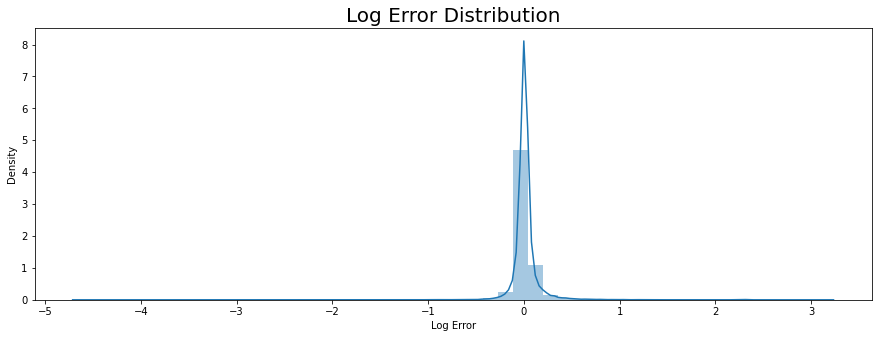

In [368]:
plt.figure(figsize=(15,5))
sns.distplot(df.log_error)
plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

In [755]:
# before we impoute the data, split the data first

from sklearn.model_selection import train_test_split

train_validate, test = train_test_split(df,test_size=0.2, random_state=123)
train, validate = train_test_split(train_validate,test_size=0.3, random_state=123)

train.shape,validate.shape, test.shape

((22566, 19), (9672, 19), (8060, 19))

In [370]:
def split_data(df):
    train_validate, test = train_test_split(df,test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate,test_size=0.3, random_state=123)
    
    return train, validate, test

In [371]:
def prep_zillow(df):
    df = clean_zillow(df)
    train, validate, test = split_data(df)
    return train, validate, test

In [740]:
# test function
df1 = raw_data
df1.head()

,basement_square_ft,bathroom,bedroom,parcelid,quality_type,finished_square_ft,garage,fips,latitude,longitude,lot_square_ft,city,pool,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date
0,NaN,3.5,4.0,14297519,NaN,3100.0,2.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,NaN,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,NaN,1.0,2.0,17052889,NaN,1465.0,1.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,NaN,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,NaN,2.0,3.0,14186244,NaN,1243.0,2.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,NaN,3.0,4.0,12177905,8.0,2376.0,NaN,6037.0,34245180.0,-118240722.0,13038.0,396551.0,1.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,NaN,3.0,4.0,12095076,9.0,2962.0,NaN,6037.0,34145202.0,-118179824.0,63000.0,47019.0,1.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [741]:
train, validate, test = prep_zillow(df1)
train.shape,validate.shape, test.shape

((22566, 19), (9672, 19), (8060, 19))

In [299]:
# start impute data on the train set

train.isnull().sum().sort_values(ascending=False)

quality_type          7864
city                   364
age                      6
yearbuilt                6
bathroom                 0
land_value               0
Ventura                  0
Orange                   0
LA                       0
transaction_date         0
log_error                0
tax                      0
structure_value          0
house_value              0
bedroom                  0
lot_square_ft            0
longitude                0
latitude                 0
county                   0
finished_square_ft       0
parcelid                 0
room_count               0
dtype: int64

In [170]:
def value_counts(col):
    return col.value_counts()

In [171]:
# Overall assessment of condition of the building from best (lowest) to worst (highest)
value_counts(train.quality_type)

6.0     5164
4.0     4368
8.0     3559
5.0      794
7.0      779
9.0       73
3.0       63
11.0       8
2.0        3
1.0        1
Name: quality_type, dtype: int64

In [174]:
(4+6+8)/3

6.0

In [172]:
train.quality_type.mean()

5.893329732649203

In [173]:
round(train.quality_type.mean())

6

In [756]:
train['quality_type'] = train.quality_type.fillna(round(train.quality_type.mean()))

In [176]:
value_counts(train.quality_type)

6.0     12938
4.0      4368
8.0      3559
5.0       794
7.0       779
9.0        73
3.0        63
11.0        8
2.0         3
1.0         1
Name: quality_type, dtype: int64

In [757]:
# drop the rest of the null value

train.dropna(inplace=True)

In [758]:
# check null
train.isnull().sum().sort_values(ascending=False)

bathroom              0
yearbuilt             0
age                   0
transaction_date      0
log_error             0
tax                   0
land_value            0
house_value           0
structure_value       0
city                  0
bedroom               0
lot_square_ft         0
longitude             0
latitude              0
county                0
finished_square_ft    0
quality_type          0
parcelid              0
room_count            0
dtype: int64

In [303]:
# write a function of imputing missing values

def impute_missing_value_zillow(df):
    df['quality_type'] = df.quality_type.fillna(round(df.quality_type.mean()))
    df.dropna(inplace=True)
    return df

In [759]:
train.shape

(22198, 19)

In [240]:
22198/22586

0.9828212166829009

## Data explore

In [427]:
train.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date,age,room_count
14844,2.5,4.0,14314108,6.0,2324.0,Orange,33.621391,-117.856428,8710.0,53571.0,1970.0,81946.0,137733.0,55787.0,1719.36,-0.013522,2017-03-31,47.0,6.5
43572,2.5,3.0,14429938,6.0,1969.0,Orange,33.486643,-117.710840,4625.0,17686.0,1989.0,265393.0,924803.0,659410.0,10282.84,0.085926,2017-08-08,28.0,5.5
17055,2.0,3.0,12481283,4.0,1656.0,LA,33.866111,-118.138917,5458.0,12292.0,1944.0,153849.0,419108.0,265259.0,5055.23,0.010107,2017-04-11,73.0,5.0
7546,2.0,3.0,12975881,5.0,1248.0,LA,34.094510,-118.016875,6244.0,51861.0,1933.0,95237.0,308440.0,213203.0,4758.08,0.085135,2017-02-21,84.0,5.0
6558,1.0,3.0,12394217,4.0,1034.0,LA,33.981847,-118.084078,4971.0,26483.0,1949.0,62655.0,271950.0,209295.0,3597.61,-0.015197,2017-02-14,68.0,4.0


In [378]:
train_explore = train[['quality_type','finished_square_ft','lot_square_ft','city','house_value','land_value',
                       'log_error','county','age','room_count','tax']]

<AxesSubplot:>

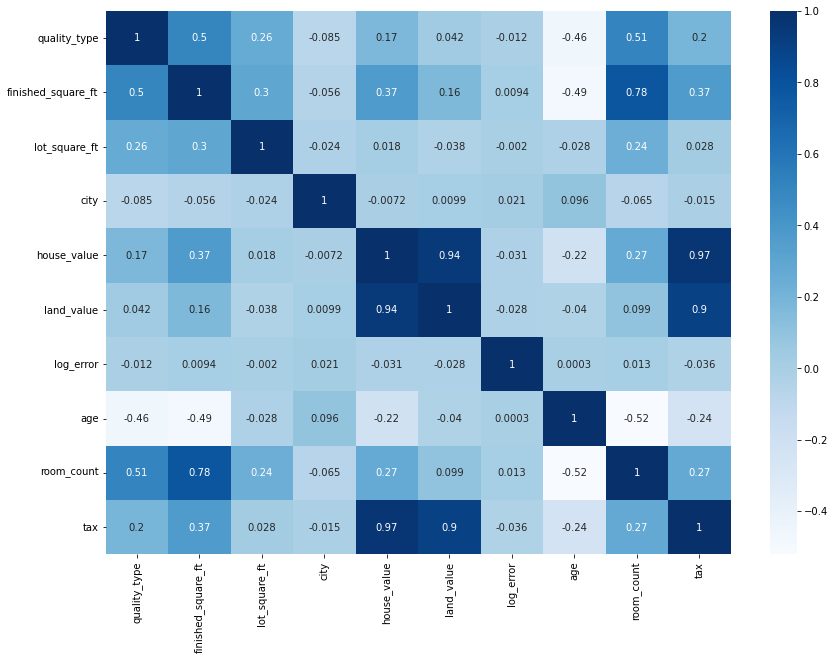

In [379]:
plt.figure(figsize=(14, 10))
sns.heatmap(train_explore.corr(), cmap='Blues', annot=True)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

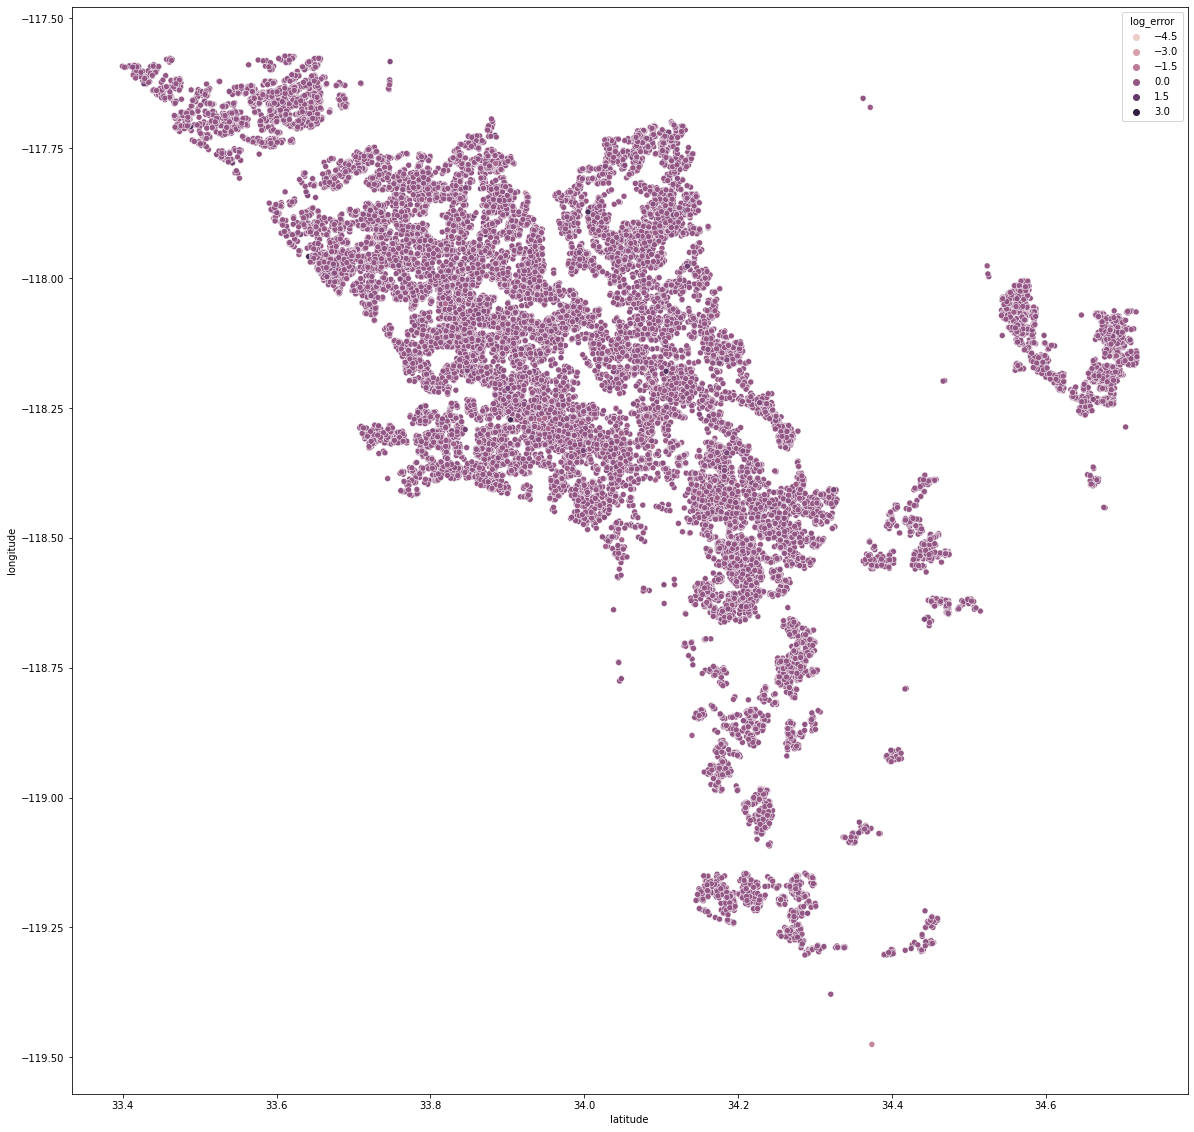

In [515]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x='latitude', y='longitude', data=train, hue='log_error')

### 1. Is there a relationship between room count and log error?

<AxesSubplot:xlabel='room_count', ylabel='log_error'>

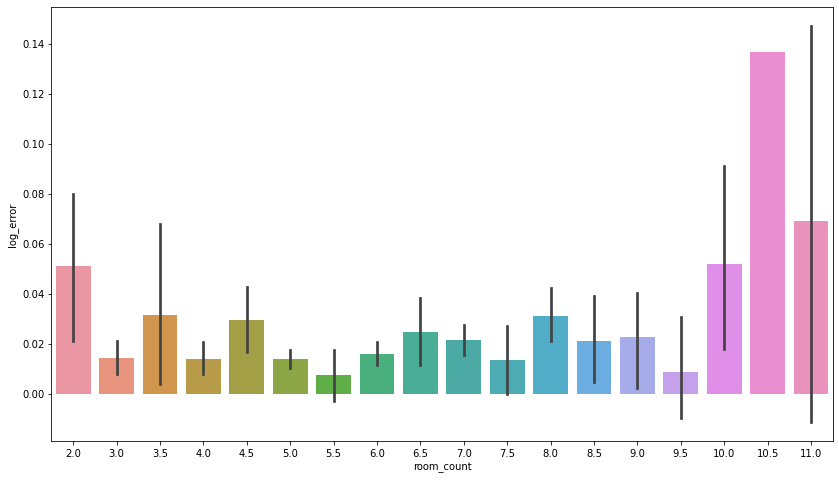

In [380]:
plt.figure(figsize=(14,8))
sns.barplot(x='room_count', y='log_error', data=train)

In [381]:
alpha = 0.05

corr, p = stats.pearsonr(train.room_count, train.log_error)

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We fail to reject the null.


### 2. is there a relationship between house age and log error?

In [428]:
train['age_bin'] = pd.cut(train.age, [0, 20, 50, 80,100,135])
train.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,yearbuilt,structure_value,house_value,land_value,tax,log_error,transaction_date,age,room_count,age_bin
14844,2.5,4.0,14314108,6.0,2324.0,Orange,33.621391,-117.856428,8710.0,53571.0,1970.0,81946.0,137733.0,55787.0,1719.36,-0.013522,2017-03-31,47.0,6.5,"(20, 50]"
43572,2.5,3.0,14429938,6.0,1969.0,Orange,33.486643,-117.710840,4625.0,17686.0,1989.0,265393.0,924803.0,659410.0,10282.84,0.085926,2017-08-08,28.0,5.5,"(20, 50]"
17055,2.0,3.0,12481283,4.0,1656.0,LA,33.866111,-118.138917,5458.0,12292.0,1944.0,153849.0,419108.0,265259.0,5055.23,0.010107,2017-04-11,73.0,5.0,"(50, 80]"
7546,2.0,3.0,12975881,5.0,1248.0,LA,34.094510,-118.016875,6244.0,51861.0,1933.0,95237.0,308440.0,213203.0,4758.08,0.085135,2017-02-21,84.0,5.0,"(80, 100]"
6558,1.0,3.0,12394217,4.0,1034.0,LA,33.981847,-118.084078,4971.0,26483.0,1949.0,62655.0,271950.0,209295.0,3597.61,-0.015197,2017-02-14,68.0,4.0,"(50, 80]"


<Figure size 720x720 with 0 Axes>

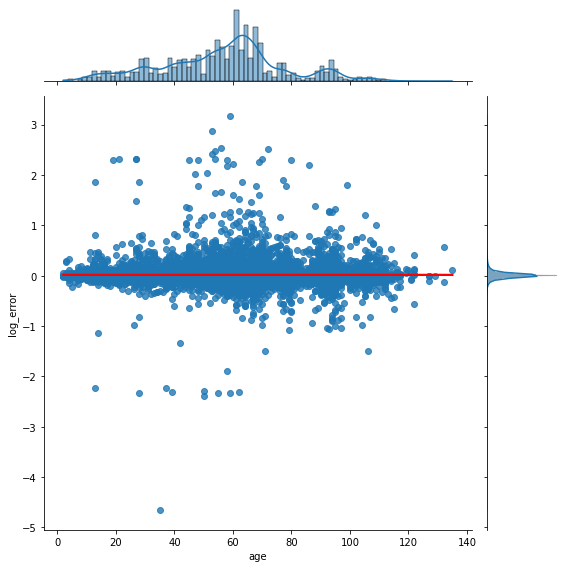

In [383]:
plt.figure(figsize=(10, 10))

sns.jointplot(x='age', y='log_error', data=train, kind='reg', line_kws={'color': 'red'}, height=8)

<AxesSubplot:xlabel='age', ylabel='log_error'>

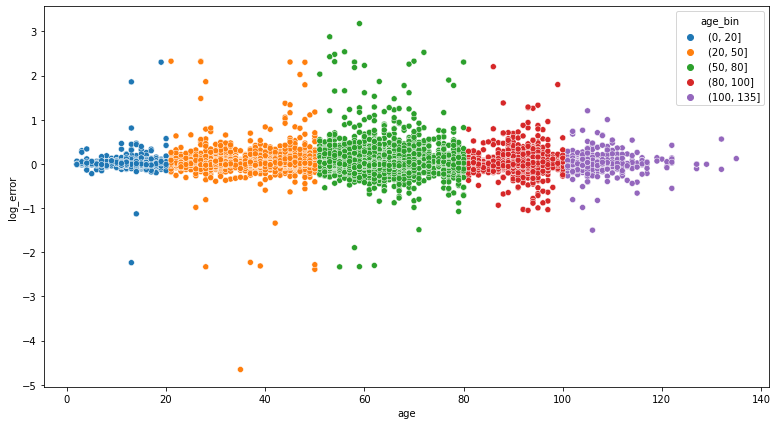

In [384]:
plt.figure(figsize=(13, 7))
sns.scatterplot(x='age', y='log_error', data=train, hue='age_bin')

H0 : age has no effect on logerror

Ha: age does have an effect on logerror

alpha = 0.05

In [385]:
from scipy.stats import pearsonr

alpha = 0.05

In [386]:
corr, p = stats.pearsonr(train.age, train.log_error)

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We fail to reject the null.


### 3. Is the log error related by location?

<AxesSubplot:xlabel='county', ylabel='log_error'>

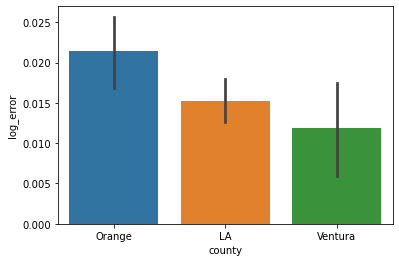

In [387]:
sns.barplot(x='county', y='log_error', data=train)

In [388]:
alpha = 0.05

f_county, p_county = stats.f_oneway(train[train['county'] == 'LA'].log_error,
                                    train[train['county'] == 'Orange'].log_error,
                                    train[train['county'] == 'Ventura'].log_error)

if p_county < alpha:
    print('We reject the null hypothesis. The log_error has a signigicantly difference in those three counties.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. The log_error has a signigicantly difference in those three counties.


### 4. why orange county has the biggest log error? is it because of the house price in orange county?

<AxesSubplot:xlabel='county', ylabel='house_value'>

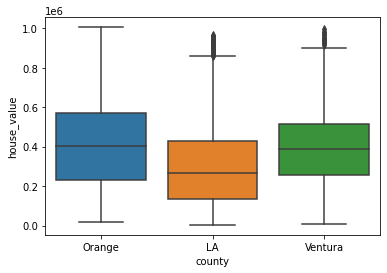

In [389]:
sns.boxplot(data = train, x='county', y='house_value')

H0: orange county average house price is <= overall average house price.

Ha: orange county average house price is > overall average house price.

In [390]:
alpha = 0.05

t_house_value_orange, p_house_value_orange = stats.ttest_1samp(train[train['county'] == 'Orange'].house_value,
                                 train['house_value'].mean())

if (p_house_value_orange/2 < alpha) & (t_house_value_orange > 0):
    print('We reject the null hypothesis. Orange county average house price is > overall average house price.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Orange county average house price is > overall average house price.


### 5. is there any relationshio between overall house value and log error?

In [429]:
train['house_value_bin'] = pd.cut(train.house_value, [0, 200_000, 500_000, 100_0000,150_0000,200_0000])
train.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,...,structure_value,house_value,land_value,tax,log_error,transaction_date,age,room_count,age_bin,house_value_bin
14844,2.5,4.0,14314108,6.0,2324.0,Orange,33.621391,-117.856428,8710.0,53571.0,...,81946.0,137733.0,55787.0,1719.36,-0.013522,2017-03-31,47.0,6.5,"(20, 50]","(0, 200000]"
43572,2.5,3.0,14429938,6.0,1969.0,Orange,33.486643,-117.710840,4625.0,17686.0,...,265393.0,924803.0,659410.0,10282.84,0.085926,2017-08-08,28.0,5.5,"(20, 50]","(500000, 1000000]"
17055,2.0,3.0,12481283,4.0,1656.0,LA,33.866111,-118.138917,5458.0,12292.0,...,153849.0,419108.0,265259.0,5055.23,0.010107,2017-04-11,73.0,5.0,"(50, 80]","(200000, 500000]"
7546,2.0,3.0,12975881,5.0,1248.0,LA,34.094510,-118.016875,6244.0,51861.0,...,95237.0,308440.0,213203.0,4758.08,0.085135,2017-02-21,84.0,5.0,"(80, 100]","(200000, 500000]"
6558,1.0,3.0,12394217,4.0,1034.0,LA,33.981847,-118.084078,4971.0,26483.0,...,62655.0,271950.0,209295.0,3597.61,-0.015197,2017-02-14,68.0,4.0,"(50, 80]","(200000, 500000]"


<AxesSubplot:xlabel='house_value', ylabel='log_error'>

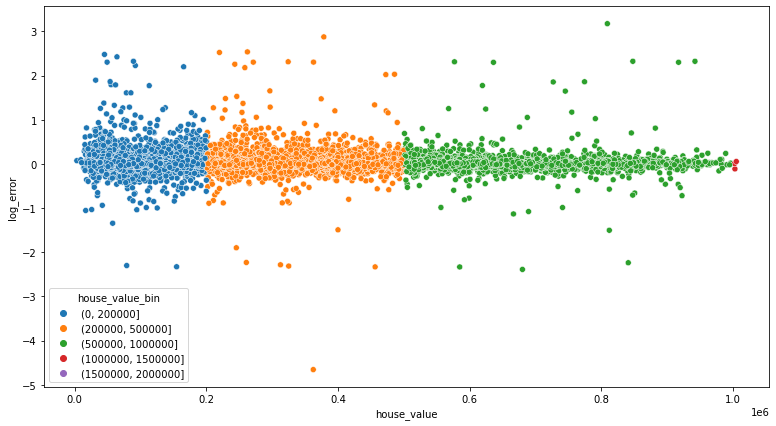

In [393]:
plt.figure(figsize=(13, 7))
sns.scatterplot(x='house_value', y='log_error', data=train, hue='house_value_bin')

In [394]:
alpha = 0.05

corr, p = stats.pearsonr(train.house_value, train.log_error)

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We reject the null hypothesis.


* house value does have a relationship with log error

### 6. Is there any relationship between sft and log error?

In [822]:
train.finished_square_ft.max()

3855.0

In [823]:
train['sft_bin'] = pd.cut(train.finished_square_ft, [0, 1000, 2000, 3000,4000])
train.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,...,structure_value,house_value,land_value,tax,log_error,transaction_date,age,room_count,baseline,sft_bin
14844,2.5,4.0,14314108,6.0,2324.0,Orange,33.621391,-117.856428,8710.0,53571.0,...,81946.0,137733.0,55787.0,1719.36,-0.013522,2017-03-31,47.0,6.5,0.016592,"(2000, 3000]"
43572,2.5,3.0,14429938,6.0,1969.0,Orange,33.486643,-117.710840,4625.0,17686.0,...,265393.0,924803.0,659410.0,10282.84,0.085926,2017-08-08,28.0,5.5,0.016592,"(1000, 2000]"
17055,2.0,3.0,12481283,4.0,1656.0,LA,33.866111,-118.138917,5458.0,12292.0,...,153849.0,419108.0,265259.0,5055.23,0.010107,2017-04-11,73.0,5.0,0.016592,"(1000, 2000]"
7546,2.0,3.0,12975881,5.0,1248.0,LA,34.094510,-118.016875,6244.0,51861.0,...,95237.0,308440.0,213203.0,4758.08,0.085135,2017-02-21,84.0,5.0,0.016592,"(1000, 2000]"
6558,1.0,3.0,12394217,4.0,1034.0,LA,33.981847,-118.084078,4971.0,26483.0,...,62655.0,271950.0,209295.0,3597.61,-0.015197,2017-02-14,68.0,4.0,0.016592,"(1000, 2000]"


<AxesSubplot:xlabel='finished_square_ft', ylabel='log_error'>

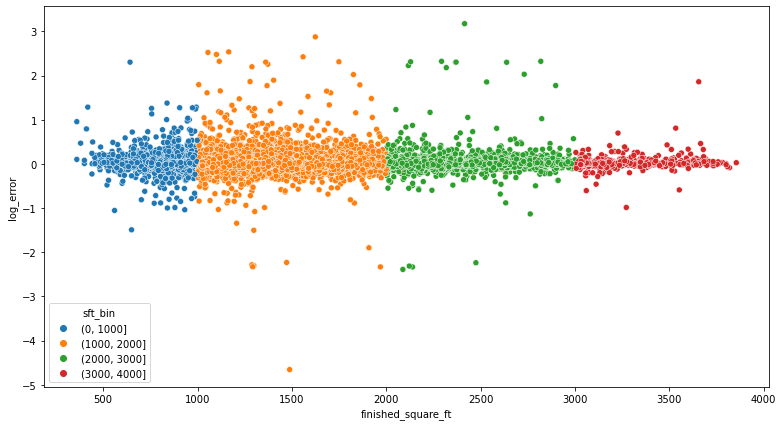

In [824]:
plt.figure(figsize=(13, 7))
sns.scatterplot(x='finished_square_ft', y='log_error', data=train, hue='sft_bin')

In [826]:
alpha = 0.05

corr_sft, p_sft = stats.pearsonr(train.finished_square_ft, train.log_error)

if p_sft < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We fail to reject the null.


### 7. is the log error related to quality type?

In [399]:
train.quality_type.value_counts()

6.0     12847
4.0      4289
8.0      3412
5.0       772
7.0       724
3.0        81
9.0        62
11.0        7
1.0         2
2.0         2
Name: quality_type, dtype: int64

<AxesSubplot:xlabel='log_error', ylabel='quality_type'>

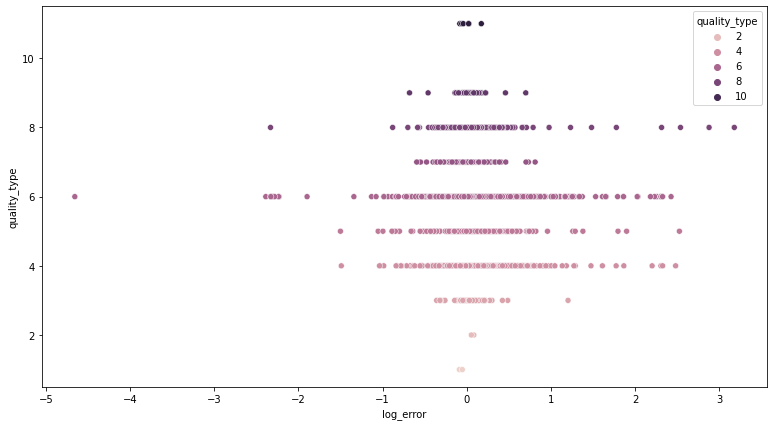

In [400]:
plt.figure(figsize=(13, 7))
sns.scatterplot(x='log_error', y='quality_type', data=train, hue='quality_type')

In [401]:
alpha = 0.05

corr, p = stats.pearsonr(train.quality_type, train.log_error)

if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null.")

We fail to reject the null.


<AxesSubplot:>

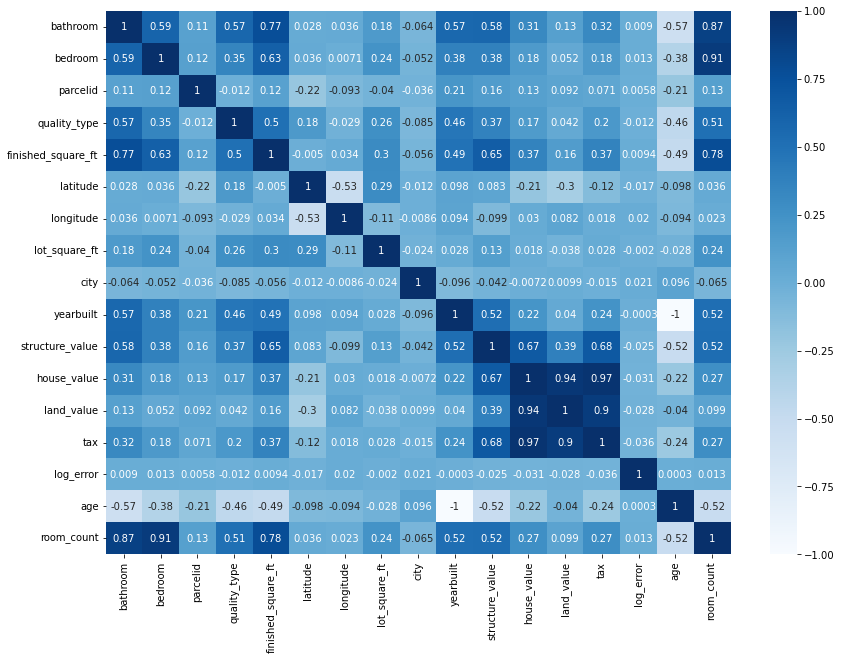

In [517]:
plt.figure(figsize=(14, 10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [403]:
county_dummies = pd.get_dummies(train['county']) 
county_dummies

,LA,Orange,Ventura
14844,0,1,0
43572,0,1,0
17055,1,0,0
7546,1,0,0
6558,1,0,0
...,...,...,...
7522,0,1,0
2689,1,0,0
45700,0,1,0
21173,0,1,0


In [802]:
x_train = train[['finished_square_ft','latitude','longitude','lot_square_ft','city',
                 'structure_value','house_value','land_value','age','room_count']]
y_train = train[['log_error']]

validate = impute_missing_value_zillow(validate)
x_validate = validate[['finished_square_ft','latitude','longitude','lot_square_ft','city',
                       'structure_value','house_value','land_value','age','room_count']]
y_validate = validate[['log_error']]

test = impute_missing_value_zillow(test)
x_test = test[['finished_square_ft','latitude','longitude','lot_square_ft','city',
               'structure_value','house_value','land_value','age','room_count']]
y_test = test[['log_error']]

county_dummies_train = pd.get_dummies(train['county']) 
county_dummies_validate = pd.get_dummies(validate['county'])
county_dummies_test = pd.get_dummies(test['county'])

In [786]:
validate.shape

(9524, 20)

In [803]:
# scale the data first
from sklearn.preprocessing import MinMaxScaler

# make the thing
scaler = MinMaxScaler()

# fit the thing on train
scaler.fit(x_train)

# use the thing (scale train)
x_train_scaled = scaler.transform(x_train)

# turn the scaled array into a dataframe
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)

In [804]:
x_validate_scaled = scaler.transform(x_validate) 
x_test_scaled = scaler.transform(x_test)

x_validate_scaled = pd.DataFrame(x_validate_scaled, columns=x_validate.columns, index=x_validate.index) 
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

In [805]:
x_train_scaled_with_dummy = pd.concat([x_train_scaled,county_dummies_train],axis=1)
x_validate_scaled_with_dummy = pd.concat([x_validate_scaled,county_dummies_validate],axis=1)
x_test_scaled_with_dummy = pd.concat([x_test_scaled,county_dummies_test],axis=1)

In [532]:
x_train_scaled_with_dummy.head()

,finished_square_ft,latitude,longitude,lot_square_ft,city,structure_value,house_value,land_value,age,room_count,LA,Orange,Ventura
14844,0.561946,0.168161,0.850746,0.650973,0.125373,0.213794,0.134232,0.072172,0.338346,0.500000,0,1,0
43572,0.460372,0.065976,0.927257,0.299363,0.033865,0.697690,0.919854,0.885906,0.195489,0.388889,0,1,0
17055,0.370815,0.353741,0.702290,0.371062,0.020110,0.403459,0.415089,0.354558,0.533835,0.333333,1,0,0
7546,0.254077,0.526945,0.766426,0.438716,0.121012,0.248853,0.304625,0.284382,0.616541,0.333333,1,0,0
6558,0.192847,0.441508,0.731109,0.329144,0.056297,0.162908,0.268202,0.279114,0.496241,0.222222,1,0,0


## cluster 1 : location (latitude, longitude, city, LA, Orange, Ventura)

In [567]:
x1 = x_train_scaled_with_dummy[['latitude', 'longitude', 'city', 'LA', 'Orange', 'Ventura']]
x1.head()

,latitude,longitude,city,LA,Orange,Ventura
14844,0.168161,0.850746,0.125373,0,1,0
43572,0.065976,0.927257,0.033865,0,1,0
17055,0.353741,0.702290,0.020110,1,0,0
7546,0.526945,0.766426,0.121012,1,0,0
6558,0.441508,0.731109,0.056297,1,0,0


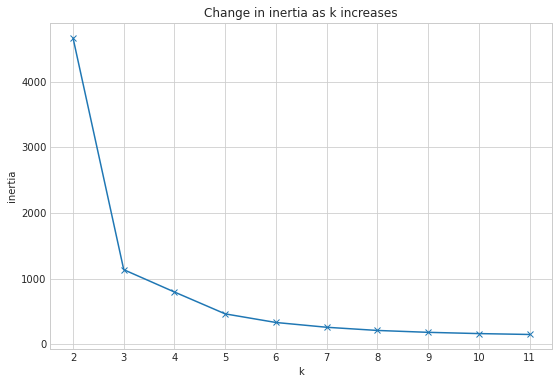

In [568]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* K = 3 

In [806]:
kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(x1)

cluster_location = kmeans1.predict(x1)
cluster_location

array([2, 2, 1, ..., 2, 2, 1], dtype=int32)

In [807]:
x_train_scaled_with_dummy['claster_location'] = cluster_location
x_train_scaled_with_dummy.head()

,finished_square_ft,latitude,longitude,lot_square_ft,city,structure_value,house_value,land_value,age,room_count,LA,Orange,Ventura,claster_location
14844,0.561946,0.168161,0.850746,0.650973,0.125373,0.213794,0.134232,0.072172,0.338346,0.500000,0,1,0,2
43572,0.460372,0.065976,0.927257,0.299363,0.033865,0.697690,0.919854,0.885906,0.195489,0.388889,0,1,0,2
17055,0.370815,0.353741,0.702290,0.371062,0.020110,0.403459,0.415089,0.354558,0.533835,0.333333,1,0,0,1
7546,0.254077,0.526945,0.766426,0.438716,0.121012,0.248853,0.304625,0.284382,0.616541,0.333333,1,0,0,1
6558,0.192847,0.441508,0.731109,0.329144,0.056297,0.162908,0.268202,0.279114,0.496241,0.222222,1,0,0,1


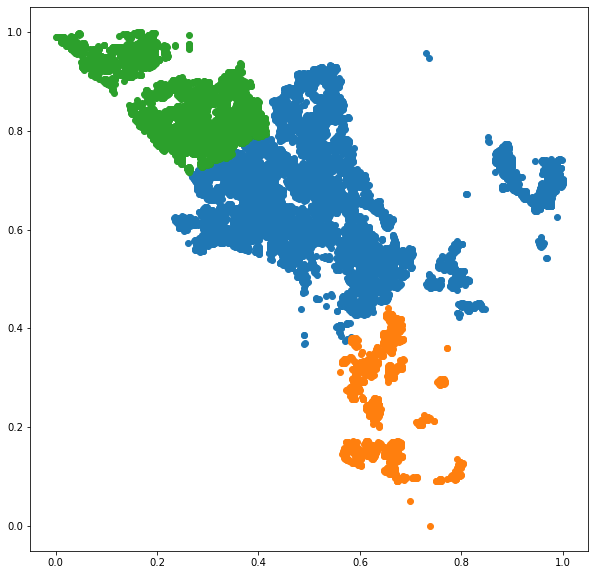

In [571]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_location.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_location == 
                                          cluster_n].latitude, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_location == cluster_n].longitude, 
                label=f'cluster_{cluster_n}')

## cluster 2 : house size and age (finished_square_ft, lot_square_ft, room_count, age)

In [572]:
x2 = x_train_scaled_with_dummy[['finished_square_ft', 'lot_square_ft', 'room_count', 'age']]
x2.head()

,finished_square_ft,lot_square_ft,room_count,age
14844,0.561946,0.650973,0.500000,0.338346
43572,0.460372,0.299363,0.388889,0.195489
17055,0.370815,0.371062,0.333333,0.533835
7546,0.254077,0.438716,0.333333,0.616541
6558,0.192847,0.329144,0.222222,0.496241


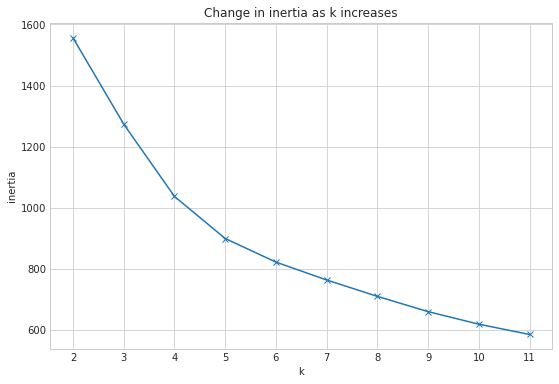

In [573]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 5

In [808]:
kmeans2 = KMeans(n_clusters=5)
kmeans2.fit(x2)

cluster_size_age = kmeans2.predict(x2)
cluster_size_age

array([4, 2, 0, ..., 0, 0, 3], dtype=int32)

In [809]:
x_train_scaled_with_dummy['claster_size_age'] = cluster_size_age
x_train_scaled_with_dummy.head()

,finished_square_ft,latitude,longitude,lot_square_ft,city,structure_value,house_value,land_value,age,room_count,LA,Orange,Ventura,claster_location,claster_size_age
14844,0.561946,0.168161,0.850746,0.650973,0.125373,0.213794,0.134232,0.072172,0.338346,0.500000,0,1,0,2,4
43572,0.460372,0.065976,0.927257,0.299363,0.033865,0.697690,0.919854,0.885906,0.195489,0.388889,0,1,0,2,2
17055,0.370815,0.353741,0.702290,0.371062,0.020110,0.403459,0.415089,0.354558,0.533835,0.333333,1,0,0,1,0
7546,0.254077,0.526945,0.766426,0.438716,0.121012,0.248853,0.304625,0.284382,0.616541,0.333333,1,0,0,1,1
6558,0.192847,0.441508,0.731109,0.329144,0.056297,0.162908,0.268202,0.279114,0.496241,0.222222,1,0,0,1,1


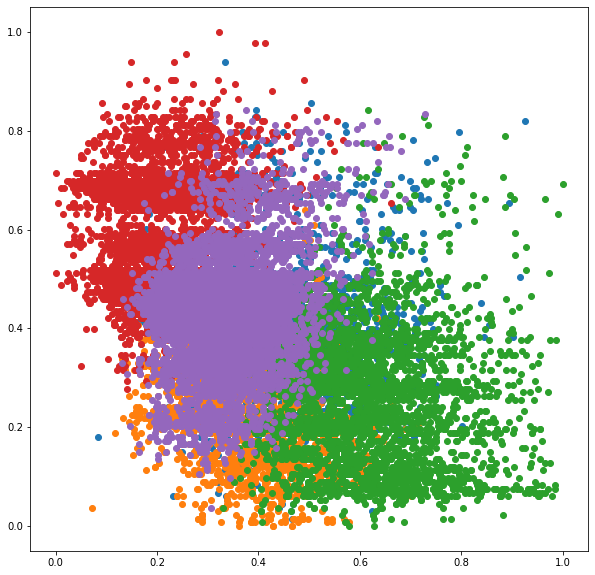

In [576]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_size_age.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_size_age == 
                                          cluster_n].finished_square_ft, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_size_age == cluster_n].age, 
                label=f'cluster_{cluster_n}')

## cluster 3 : price (structure_value, house_value, land_value)

In [ ]:
# house value and land valua are 94% related, but I will still use all of them

In [578]:
x3 = x_train_scaled_with_dummy[['structure_value', 'house_value','land_value']]
x3.head()

,structure_value,house_value,land_value
14844,0.213794,0.134232,0.072172
43572,0.697690,0.919854,0.885906
17055,0.403459,0.415089,0.354558
7546,0.248853,0.304625,0.284382
6558,0.162908,0.268202,0.279114


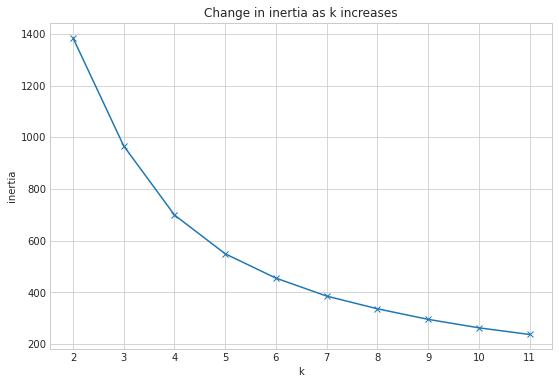

In [579]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 4

In [810]:
kmeans3 = KMeans(n_clusters=4)
kmeans3.fit(x3)

cluster_price = kmeans3.predict(x3)
cluster_price

array([3, 1, 0, ..., 2, 3, 3], dtype=int32)

In [811]:
x_train_scaled_with_dummy['claster_price'] = cluster_price
x_train_scaled_with_dummy.head()

,finished_square_ft,latitude,longitude,lot_square_ft,city,structure_value,house_value,land_value,age,room_count,LA,Orange,Ventura,claster_location,claster_size_age,claster_price
14844,0.561946,0.168161,0.850746,0.650973,0.125373,0.213794,0.134232,0.072172,0.338346,0.500000,0,1,0,2,4,3
43572,0.460372,0.065976,0.927257,0.299363,0.033865,0.697690,0.919854,0.885906,0.195489,0.388889,0,1,0,2,2,1
17055,0.370815,0.353741,0.702290,0.371062,0.020110,0.403459,0.415089,0.354558,0.533835,0.333333,1,0,0,1,0,0
7546,0.254077,0.526945,0.766426,0.438716,0.121012,0.248853,0.304625,0.284382,0.616541,0.333333,1,0,0,1,1,0
6558,0.192847,0.441508,0.731109,0.329144,0.056297,0.162908,0.268202,0.279114,0.496241,0.222222,1,0,0,1,1,0


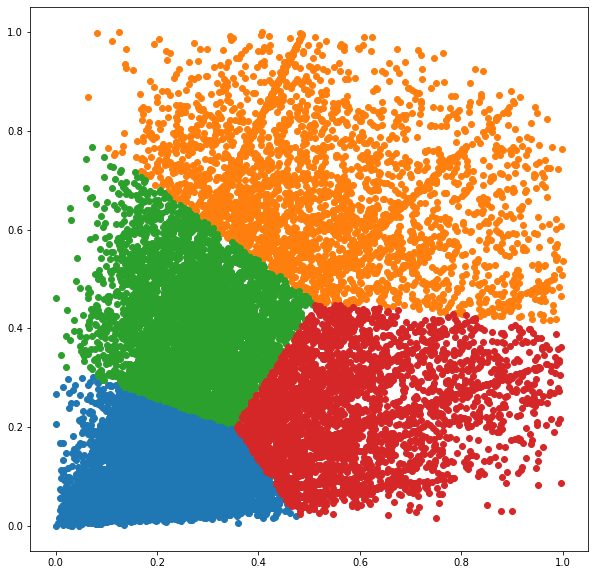

In [582]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_price.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_price == 
                                          cluster_n].structure_value, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_price == cluster_n].land_value, 
                label=f'cluster_{cluster_n}')

In [812]:
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_location'])
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_size_age'])
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_price'])

In [584]:
x_train_scaled_with_dummy.head()

,finished_square_ft,latitude,longitude,lot_square_ft,city,structure_value,house_value,land_value,age,room_count,...,claster_location_2,claster_size_age_0,claster_size_age_1,claster_size_age_2,claster_size_age_3,claster_size_age_4,claster_price_0,claster_price_1,claster_price_2,claster_price_3
14844,0.561946,0.168161,0.850746,0.650973,0.125373,0.213794,0.134232,0.072172,0.338346,0.500000,...,1,0,0,1,0,0,1,0,0,0
43572,0.460372,0.065976,0.927257,0.299363,0.033865,0.697690,0.919854,0.885906,0.195489,0.388889,...,1,0,1,0,0,0,0,1,0,0
17055,0.370815,0.353741,0.702290,0.371062,0.020110,0.403459,0.415089,0.354558,0.533835,0.333333,...,0,0,0,0,0,1,0,0,1,0
7546,0.254077,0.526945,0.766426,0.438716,0.121012,0.248853,0.304625,0.284382,0.616541,0.333333,...,0,0,0,0,1,0,0,0,1,0
6558,0.192847,0.441508,0.731109,0.329144,0.056297,0.162908,0.268202,0.279114,0.496241,0.222222,...,0,0,0,0,1,0,0,0,1,0


## select k best

In [813]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

kbest = SelectKBest(f_regression, k=5)
kbest.fit(x_train_scaled_with_dummy, y_train)

SelectKBest(k=5, score_func=<function f_regression at 0x7f8ef17a95e0>)

In [663]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train_scaled_with_dummy.columns)
kbest_results

,p,f
finished_square_ft,0.163404,1.942571
latitude,0.011683,6.359399
longitude,0.003462,8.548473
lot_square_ft,0.770129,0.085387
city,0.001738,9.810392
structure_value,0.000229,13.578733
house_value,0.000003,21.893529
land_value,0.000030,17.415179
age,0.964216,0.002013
room_count,0.060542,3.522822


In [814]:
x_train_scaled_with_dummy.columns[kbest.get_support()]

Index(['city', 'structure_value', 'house_value', 'land_value',
       'claster_price_3'],
      dtype='object')

### Recursive Feature Elimination

In [815]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lm = LinearRegression()

rfe = RFE(lm, n_features_to_select=5)

rfe.fit(x_train_scaled_with_dummy,y_train)  

feature_mask = rfe.support_

rfe_feature = x_train_scaled_with_dummy.iloc[:,feature_mask].columns.tolist()
rfe_feature

['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']

### Select K best : 'city', 'structure_value', 'house_value', 'land_value', 'claster_price_0'

In [816]:
x_train_k_best = x_train_scaled_with_dummy[['city', 'structure_value', 'house_value', 'land_value','claster_price_3']]
x_train_k_best.head()

,city,structure_value,house_value,land_value,claster_price_3
14844,0.125373,0.213794,0.134232,0.072172,1
43572,0.033865,0.697690,0.919854,0.885906,0
17055,0.020110,0.403459,0.415089,0.354558,0
7546,0.121012,0.248853,0.304625,0.284382,0
6558,0.056297,0.162908,0.268202,0.279114,0


In [667]:
y_train.head()

,log_error
14844,-0.013522
43572,0.085926
17055,0.010107
7546,0.085135
6558,-0.015197


In [592]:
train.head()

,bathroom,bedroom,parcelid,quality_type,finished_square_ft,county,latitude,longitude,lot_square_ft,city,...,house_value,land_value,tax,log_error,transaction_date,age,room_count,age_bin,house_value_bin,sft_bin
14844,2.5,4.0,14314108,6.0,2324.0,Orange,33.621391,-117.856428,8710.0,53571.0,...,137733.0,55787.0,1719.36,-0.013522,2017-03-31,47.0,6.5,"(20, 50]","(0, 200000]","(2000, 3000]"
43572,2.5,3.0,14429938,6.0,1969.0,Orange,33.486643,-117.710840,4625.0,17686.0,...,924803.0,659410.0,10282.84,0.085926,2017-08-08,28.0,5.5,"(20, 50]","(500000, 1000000]","(1000, 2000]"
17055,2.0,3.0,12481283,4.0,1656.0,LA,33.866111,-118.138917,5458.0,12292.0,...,419108.0,265259.0,5055.23,0.010107,2017-04-11,73.0,5.0,"(50, 80]","(200000, 500000]","(1000, 2000]"
7546,2.0,3.0,12975881,5.0,1248.0,LA,34.094510,-118.016875,6244.0,51861.0,...,308440.0,213203.0,4758.08,0.085135,2017-02-21,84.0,5.0,"(80, 100]","(200000, 500000]","(1000, 2000]"
6558,1.0,3.0,12394217,4.0,1034.0,LA,33.981847,-118.084078,4971.0,26483.0,...,271950.0,209295.0,3597.61,-0.015197,2017-02-14,68.0,4.0,"(50, 80]","(200000, 500000]","(1000, 2000]"


In [764]:
#Establish baselines for the train and validation subsets
from math import sqrt
from sklearn.metrics import mean_squared_error

baseline = train.log_error.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.log_error, train.baseline))
validate_rmse = sqrt(mean_squared_error(validate.log_error, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.1602198258872418.


Models:
    
1. Linear Regression
2. Lasso-Lars
3. TweedieRegressor
4. 2nd degree Polynomial
5. Interaction only polynomial

In [817]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

predictions_train_k_best_model = pd.DataFrame({'actual': train.log_error})
predictions_train_k_best_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_k_best, y_train)
predictions_train_k_best_model['lm'] = lm.predict(x_train_k_best)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_k_best, y_train)
predictions_train_k_best_model['lasso_lars'] = lars.predict(x_train_k_best)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_k_best, y_train)
predictions_train_k_best_model['glm'] = glm.predict(x_train_k_best)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_k_best)
x_train_k_best_poly = pd.DataFrame(
    poly.transform(x_train_k_best),
    columns=poly.get_feature_names(x_train_k_best.columns),
    index=train.index)
lm1 = LinearRegression()
lm1.fit(x_train_k_best_poly, y_train)
x_train_poly = poly.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_degree_2'] = lm1.predict(x_train_k_best_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_k_best)
x_train_k_best_poly1 = pd.DataFrame(
    poly1.transform(x_train_k_best),
    columns=poly1.get_feature_names(x_train_k_best.columns),
    index=train.index)
lm1.fit(x_train_k_best_poly1, y_train)
x_train_poly1 = poly1.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_only_interaction'] = lm1.predict(x_train_k_best_poly1)
predictions_train_k_best_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
14844,-0.013522,0.016592,0.024602,0.016592,0.018256,0.029257,0.023918
43572,0.085926,0.016592,0.007772,0.016592,0.014462,0.020254,0.022779
17055,0.010107,0.016592,0.010821,0.016592,0.015524,0.008329,0.011206
7546,0.085135,0.016592,0.014219,0.016592,0.015822,0.021354,0.016382
6558,-0.015197,0.016592,0.012990,0.016592,0.015889,0.019671,0.019614


## evaluat the model

In [766]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.1602198258872418.


In [818]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_k_best_model.actual, y_predicted))
predictions_train_k_best_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.160121
polynomial_only_interaction    0.160168
lm                             0.160248
glm                            0.160341
baseline                       0.160387
lasso_lars                     0.160387
dtype: float64

In [768]:
def calculate_r2(y_predicted):
    return r2_score(predictions_train_k_best_model.actual, y_predicted)

predictions_train_k_best_model.apply(calculate_r2).sort_values()

baseline                       0.000000
lasso_lars                     0.000000
glm                            0.000228
lm                             0.001848
polynomial_only_interaction    0.003219
polynomial_degree_2            0.003830
actual                         1.000000
dtype: float64

## RFE : 'finished_square_ft',  'city', 'structure_value', 'house_value', 'room_count'

In [819]:
x_train_rfe = x_train_scaled_with_dummy[['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']]
x_train_rfe.head()

,finished_square_ft,latitude,city,structure_value,room_count
14844,0.561946,0.168161,0.125373,0.213794,0.500000
43572,0.460372,0.065976,0.033865,0.697690,0.388889
17055,0.370815,0.353741,0.020110,0.403459,0.333333
7546,0.254077,0.526945,0.121012,0.248853,0.333333
6558,0.192847,0.441508,0.056297,0.162908,0.222222


In [820]:
predictions_train_rfe_model = pd.DataFrame({'actual': train.log_error})
predictions_train_rfe_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lm'] = lm.predict(x_train_rfe)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lasso_lars'] = lars.predict(x_train_rfe)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['glm'] = glm.predict(x_train_rfe)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(
    poly.transform(x_train_rfe),
    columns=poly.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
x_train_poly = poly.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_degree_2'] = lm1.predict(x_train_rfe_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_rfe)
x_train_rfe_poly1 = pd.DataFrame(
    poly1.transform(x_train_rfe),
    columns=poly1.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1.fit(x_train_rfe_poly1, y_train)
x_train_poly1 = poly1.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_only_interaction'] = lm1.predict(x_train_rfe_poly1)
predictions_train_rfe_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
14844,-0.013522,0.016592,0.034459,0.016592,0.016922,0.034883,0.030484
43572,0.085926,0.016592,0.008126,0.016592,0.016495,0.012845,0.008414
17055,0.010107,0.016592,0.013208,0.016592,0.016526,0.001956,0.008534
7546,0.085135,0.016592,0.016927,0.016592,0.016571,0.020007,0.017519
6558,-0.015197,0.016592,0.015707,0.016592,0.016592,0.015967,0.018387


In [660]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.1602198258872418.


In [821]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_rfe_model.actual, y_predicted))
predictions_train_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.159977
polynomial_only_interaction    0.160071
lm                             0.160190
glm                            0.160379
baseline                       0.160387
lasso_lars                     0.160387
dtype: float64

In [772]:
def calculate_r2(y_predicted):
    return r2_score(predictions_train_rfe_model.actual, y_predicted)

predictions_train_rfe_model.apply(calculate_r2).sort_values()

baseline                       0.000000
lasso_lars                     0.000000
glm                            0.000154
lm                             0.002542
polynomial_only_interaction    0.004891
polynomial_degree_2            0.005878
actual                         1.000000
dtype: float64

# RFE works better!!!

* top three models are:
    1. 2nd degree polynomial 
    2. Interaction only polynomial
    3. Linear Regression
    
    
    * 'finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count'

In [ ]:
# fit on validate set

In [773]:
x_validate_scaled_with_dummy.shape

(9524, 13)

In [782]:
x_train_rfe.shape

(22198, 5)

In [779]:
x_validate_rfe.shape

(9524, 5)

In [783]:
predictions_validate_rfe_model.shape

(9672, 1)

In [784]:
validate.shape

(9672, 20)

In [775]:
x_validate_rfe = x_validate_scaled_with_dummy[['finished_square_ft', 'city', 'structure_value', 'house_value', 'room_count']]
x_validate_rfe.head()

,finished_square_ft,city,structure_value,house_value,room_count
1103,0.484120,0.126602,0.406419,0.275564,0.444444
7910,0.465522,0.022298,0.423839,0.456977,0.555556
1339,0.450930,0.125587,0.744898,0.431773,0.500000
45475,0.375107,0.020505,0.337913,0.595648,0.333333
105,0.346209,0.020505,0.193934,0.245907,0.444444


In [788]:
predictions_validate_rfe_model = pd.DataFrame({'actual': validate.log_error})

lm.fit(x_train_rfe, y_train)
predictions_validate_rfe_model['lm'] = lm.predict(x_validate_rfe)

lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
predictions_validate_rfe_model['polynomial_degree_2'] = lm1.predict(poly.transform(x_validate_rfe))

lm1.fit(x_train_rfe_poly1, y_train)
predictions_validate_rfe_model['polynomial_only_interaction'] = lm1.predict(poly1.transform(x_validate_rfe))
predictions_validate_rfe_model.head()

,actual,lm,polynomial_degree_2,polynomial_only_interaction
1103,0.037393,0.021818,0.018363,0.015830
7910,0.004254,0.016848,0.018061,0.018995
1339,0.005471,0.009099,0.006051,0.003375
45475,-0.006522,0.010761,0.000590,0.006113
105,0.007143,0.021601,0.017785,0.020103


In [661]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.1602198258872418.


In [789]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_validate_rfe_model.actual, y_predicted))
predictions_validate_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_only_interaction    0.160480
polynomial_degree_2            0.160537
lm                             0.160592
dtype: float64

In [790]:
def calculate_r2(y_predicted):
    return r2_score(predictions_validate_rfe_model.actual, y_predicted)

predictions_validate_rfe_model.apply(calculate_r2).sort_values()

lm                             0.003348
polynomial_degree_2            0.004038
polynomial_only_interaction    0.004745
actual                         1.000000
dtype: float64

## fit the best model (Interaction only polynomial) on test set

In [791]:
x_test_rfe = x_test_scaled_with_dummy[['finished_square_ft', 'city', 'structure_value', 'house_value', 'room_count']]
x_test_rfe.head()

,finished_square_ft,city,structure_value,house_value,room_count
1050,0.218884,0.052087,0.178088,0.403933,0.277778
366,0.474964,0.020505,0.130756,0.114208,0.222222
7432,0.476395,0.010144,0.294151,0.311303,0.333333
4931,0.205722,0.091345,0.180338,0.083171,0.333333
38173,0.321888,0.050590,0.145841,0.071410,0.333333


In [792]:
# re-create our interaction only polynomial model
poly_test = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_test.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(poly_test.transform(x_train_rfe),
                            columns=poly_test.get_feature_names(x_train_rfe.columns),index=train.index)
lm_test_rfe = LinearRegression()
lm_test_rfe.fit(x_train_rfe_poly, y_train)

x_test_rfe_poly = poly_test.transform(x_test_rfe)
test_predictions = lm_test_rfe.predict(x_test_rfe_poly)
test_actual = test.log_error

In [654]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.1602198258872418.


In [793]:
# RMSE
sqrt(mean_squared_error(test_actual, test_predictions))

0.17219240521784793

In [794]:
# R2 score
r2_score(test_actual, test_predictions)

0.001997696313609576

In [800]:
print('RMSE for 2nd Degree Polynomial model on the train dataset: {}'.format(sqrt(mean_squared_error(predictions_train_rfe_model.actual, predictions_train_rfe_model.polynomial_only_interaction))))
print('RMSE for 2nd Degree Polynomial model on the validate dataset: {}'.format(sqrt(mean_squared_error(predictions_validate_rfe_model.actual, predictions_validate_rfe_model.polynomial_only_interaction))))
print('RMSE for 2nd Degree Polynomial model on the test dataset: {}'.format(sqrt(mean_squared_error(test_actual, test_predictions))))

RMSE for 2nd Degree Polynomial model on the train dataset: 0.15999438168131272
RMSE for 2nd Degree Polynomial model on the validate dataset: 0.16047962608879854
RMSE for 2nd Degree Polynomial model on the test dataset: 0.17219240521784793


In [796]:
print('R2 for 2nd Degree Polynomial model on the train dataset: {:.2}'.format(r2_score(predictions_train_rfe_model.actual, predictions_train_rfe_model.polynomial_only_interaction)))
print('R2 for 2nd Degree Polynomial model on the validate dataset: {:.2}'.format(r2_score(predictions_train_rfe_model.actual, predictions_train_rfe_model.polynomial_only_interaction)))
print('R2 for 2nd Degree Polynomial model on the test dataset: {:.2}'.format(r2_score(test_actual, test_predictions)))

R2 for 2nd Degree Polynomial model on the train dataset: 0.0049
R2 for 2nd Degree Polynomial model on the validate dataset: 0.0049
R2 for 2nd Degree Polynomial model on the test dataset: 0.002


Text(0.5, 1.0, 'Actual vs predicted log error with polynomial_only_interaction')

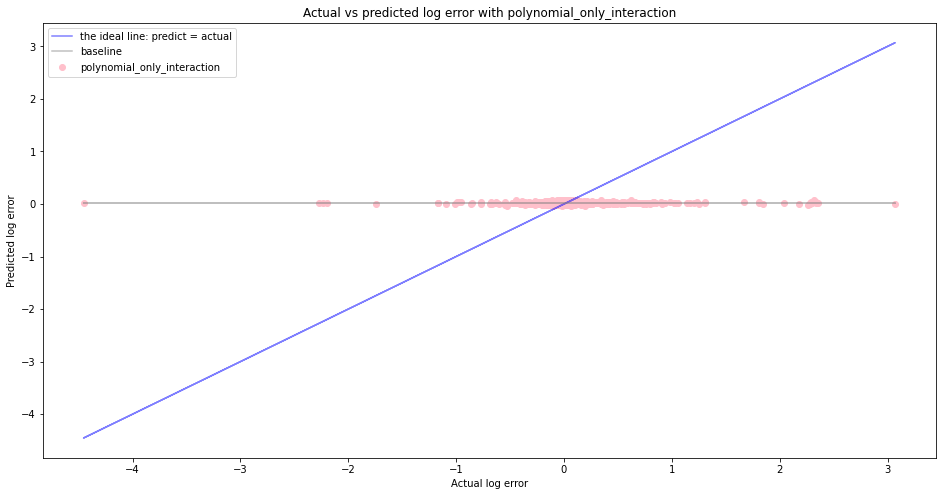

In [797]:
predictions_test_rfe = pd.DataFrame({'actual': test.log_error})
predictions_test_rfe['polynomial_only_interaction'] = lm_test_rfe.predict(poly_test.transform(x_test_rfe))
predictions_test_rfe['baseline'] = baseline

plt.figure(figsize=(16,8))

plt.plot(predictions_test_rfe['actual'], predictions_test_rfe['actual'], alpha=0.5,
         color='blue', label='the ideal line: predict = actual')
plt.plot(predictions_test_rfe['actual'], predictions_test_rfe['baseline'], alpha=0.5,
         color='gray', label='baseline')

plt.scatter(predictions_test_rfe['actual'], predictions_test_rfe['polynomial_only_interaction'],
            color='pink', label='polynomial_only_interaction')

plt.legend()
plt.xlabel('Actual log error')
plt.ylabel('Predicted log error')
plt.title('Actual vs predicted log error with polynomial_only_interaction')

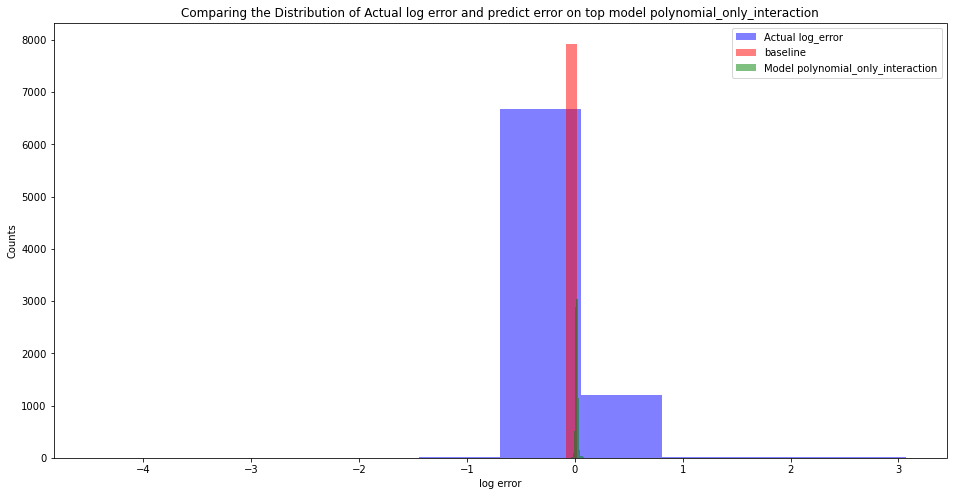

In [827]:
plt.figure(figsize=(16,8))

plt.hist(predictions_test_rfe.actual, color='blue', alpha=.5, label="Actual log_error")
plt.hist(predictions_test_rfe.baseline, color='red', alpha=.5, label="baseline")
plt.hist(predictions_test_rfe.polynomial_only_interaction, color='green', alpha=.5, label="Model polynomial_only_interaction")
plt.xlabel("log error")
plt.ylabel("Counts")
plt.title("Comparing the Distribution of Actual log error and predict error on top model polynomial_only_interaction")
plt.legend()
plt.show()

(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.100e+01, 6.673e+03,
        1.201e+03, 2.000e+01, 1.100e+01, 6.000e+00]),
 array([-4.453964  , -3.70163111, -2.94929823, -2.19696534, -1.44463246,
        -0.69229957,  0.06003331,  0.8123662 ,  1.56469908,  2.31703197,
         3.06936485]),
 <BarContainer object of 10 artists>)

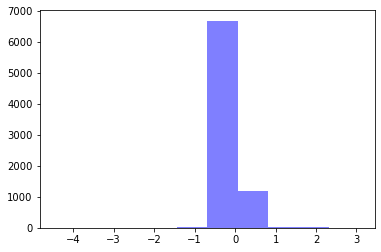

In [828]:
plt.hist(y_test, color='blue', alpha=.5, label="Actual log_error")

In [830]:
predictions_test_rfe.head()

,actual,polynomial_only_interaction,baseline
1050,0.122056,0.010982,0.016592
366,-0.010863,0.022776,0.016592
7432,0.011261,0.014871,0.016592
4931,0.662606,0.024642,0.016592
38173,0.018790,0.024895,0.016592


## It look like our model doesn't beat the baseline  :(